<span style=" font-size: 30px;">Introduction</span><br><br>
At HU, I aim to build a tool to measure student engagement, and then based on that I can predict the risk of failure of a specific student. To do that I need more data in the future phases to measure exactly engagement and then I can improve the accuracy of the risk of failure. By the way, the dataset that I am using has some useable elements like the sum of the clicks,final result, and score, etc. So I think that would be a good start to determine whether it’s possible to predict the dropout of a student at all without considering engagement as one of the main factors of the learning outcome.



goal:
The goal of this project is to predict students' engagement or progress based on the provided dataset, consisting of information about students and their interactions with the virtual learning environment (VLE).




<span style=" font-size: 30px;">Dataset:</span><br><br>

The dataset from the "Open University Learning Analytics dataset" is a valuable resource for this phase. 
It encompasses information on available modules and presentations, providing insights into assessments, 
including types and weights. In the VLE, it specifies activity types and week intervals. The dataset also 
covers comprehensive demographic details, educational backgrounds, and student results. Additionally, it 
includes information on student registration and unregistration dates, assessment results with submission 
dates and scores, and detailed records of student interactions with VLE materials, capturing dates and 
interaction counts.


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import requests
import csv


  <span style=" font-size: 20px;">API Holiday:</span><br><br>


one of the engagement metrics is frequency and intensity of access to canvas and log data. Understanding when holidays occur allows the system to make decisions in subsequent actions, such as excluding certain measurements like log data during holiday periods.
Integrating holiday data into predictive models might enhance the accuracy of predictions by accounting for external events that can influence engagement.
It’s good to consider adjustments to account for holiday-related factors. This might involve creating specific features in the model that capture the influence of holidays on student engagement. Moreover, Allowing teachers to receive insights specifically related to holiday impact on student engagement. This can help them plan their instructional strategies more effectively, considering the unique challenges and opportunities presented by holiday periods.


It’s good to say that the purpose of using that API in that phase is that show that I can use API systems and various data.


In [85]:



response = requests.get(f"https://calendarific.com/api/v2/holidays?api_key=8Fta2zLzPyVIsJpf5VkOhtbASUA3NVaB&country=NL&year=2022")

if response.status_code == 200:
    holidays_data = response.json()

    for holiday in holidays_data['response']['holidays']:
        print(holiday)

    with open('holidays_nl_2022_calendarific.csv', mode='w', newline='', encoding='utf-8') as csv_file:
        fieldnames = ['name', 'date', 'type']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        writer.writeheader()

        for holiday in holidays_data['response']['holidays']:
            writer.writerow({
                'name': holiday['name'],
                'date': holiday['date']['iso'],
                'type': ', '.join(holiday['type'])
            })

else:
    print(f"Error: {response.status_code}")
    print(response.content)

{'name': "New Year's Day", 'description': "New Year's Day (nieuwjaarsdag, oud en nieuw) is the first day of a new calendar year. In the Netherlands, it always falls on January 1.", 'country': {'id': 'nl', 'name': 'Netherlands'}, 'date': {'iso': '2022-01-01', 'datetime': {'year': 2022, 'month': 1, 'day': 1}}, 'type': ['National holiday'], 'primary_type': 'Public Holiday', 'canonical_url': 'https://calendarific.com/holiday/netherlands/new-year-day', 'urlid': 'netherlands/new-year-day', 'locations': 'All', 'states': 'All'}
{'name': "Valentine's Day", 'description': "February 14 is Valentine's Day or Saint Valentine's Feast. The day of love owes its origins to ancient Roman and European Christian traditions.", 'country': {'id': 'nl', 'name': 'Netherlands'}, 'date': {'iso': '2022-02-14', 'datetime': {'year': 2022, 'month': 2, 'day': 14}}, 'type': ['Observance'], 'primary_type': 'Observance', 'canonical_url': 'https://calendarific.com/holiday/netherlands/valentine-day', 'urlid': 'netherlands

Getting Datasets and Exploration : 

I got all the data sets and get info and describe to see what they do and which part needs cleaning and pre-processing

In [86]:
df_assessment = pd.read_csv("studentAssessment.csv")
df_info = pd.read_csv("studentInfo.csv")
df_registration = pd.read_csv("studentRegistration.csv")
df_vle = pd.read_csv("vle.csv")
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_vlestudent = pd.read_csv("studentVle.csv")

In [4]:
print("\nInfo DataFrame:")
df_info.info()
print("\nInfo DataFrame Description:")
df_info.describe()




Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB

Info DataFrame Description:


,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


In [5]:
print("\nRegistration DataFrame:")
df_registration.info()
print("\nRegistration DataFrame Description:")
df_registration.describe()




Registration DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB

Registration DataFrame Description:


,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


In [6]:
print("\nVLE DataFrame:")
df_vle.info()
print("\nVLE DataFrame Description:")
df_vle.describe()



VLE DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB

VLE DataFrame Description:


,id_site,week_from,week_to
count,6.364000e+03,1121.000000,1121.000000
mean,7.260991e+05,15.204282,15.214987
std,1.283151e+05,8.792865,8.779806
min,5.267210e+05,0.000000,0.000000
25%,6.615928e+05,8.000000,8.000000
50%,7.300965e+05,15.000000,15.000000
75%,8.140162e+05,22.000000,22.000000
max,1.077905e+06,29.000000,29.000000


In [7]:
print("\nAssessments DataFrame:")
df_assessments.info()
print("\nAssessments DataFrame Description:")
df_assessments.describe()


Assessments DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB

Assessments DataFrame Description:


,id_assessment,date,weight
count,206.000000,195.000000,206.000000
mean,26473.975728,145.005128,20.873786
std,10098.625521,76.001119,30.384224
min,1752.000000,12.000000,0.000000
25%,15023.250000,71.000000,0.000000
50%,25364.500000,152.000000,12.500000
75%,34891.750000,222.000000,24.250000
max,40088.000000,261.000000,100.000000


In [8]:
print("\nCourses DataFrame:")
df_courses.info()
print("\nCourses DataFrame Description:")
df_courses.describe()


Courses DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes

Courses DataFrame Description:


,module_presentation_length
count,22.000000
mean,255.545455
std,13.654677
min,234.000000
25%,241.000000
50%,261.500000
75%,268.000000
max,269.000000


I converted df_vlestudent['date'] to standard format and also handling errors to convert any cells that is not time

grouping the 'df_vlestudent' DataFrame by the specified columns, calculates the sum of all values for each group, and resets the index. This creates a new DataFrame,that summarizes the student interactions with the VLE for each module, presentation, and student ID.
I also mapped categorical values in 'final_result' column to numerical values.


At first I thought gender can be important because I didn't nmormalize the statics so I thought women are more likely to pass. then, I found that it's not that related factor by normalizing

c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

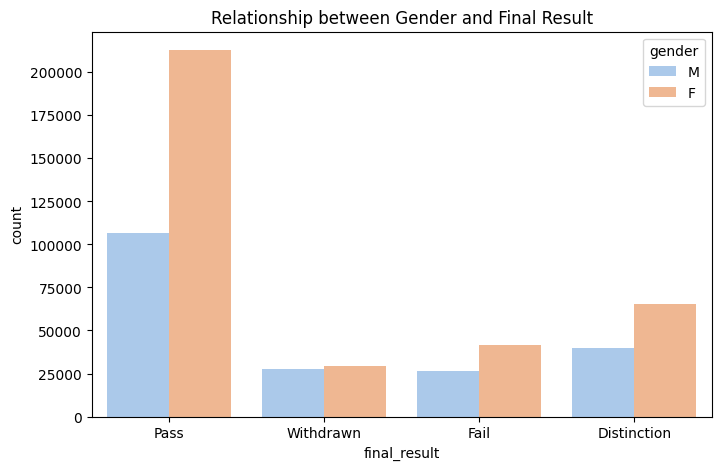

In [87]:
df_vlestudent['date'] = pd.to_datetime(df_vlestudent['date'], errors='coerce')

df_student_vle_grouped = df_vlestudent.groupby(['code_module', 'code_presentation', 'id_student', 'date']).sum().reset_index()
df_merged = pd.merge(df_info, df_student_vle_grouped, on=['code_module', 'code_presentation', 'id_student'], how='inner')



# '%' 
df_merged['imd_band'] = df_merged['imd_band'].replace({'%': ''}, regex=True)

df_merged['imd_band'].fillna('Missing', inplace=True)

# relationship between Gender and Final Result
plt.figure(figsize=(8, 5))
sns.countplot(x='final_result', hue='gender', data=df_merged, palette='pastel')
plt.title('Relationship between Gender and Final Result')
plt.show()



#normalizing 





# df_merged['gender_final'] = df_merged['gender'].astype(str) + '_' + df_merged['final_result'].astype(str)

# # Calculate the proportions manually
# proportions = df_merged.groupby('gender_final').size().groupby(level=0).apply(lambda x: x / x.sum())

# # Plot the normalized bar plot
# plt.figure(figsize=(8, 5))
# proportions.unstack().plot(kind='bar', stacked=True)
# plt.title('Relationship between Gender and Final Result (Normalized)')
# plt.xlabel('Final Result')
# plt.ylabel('Proportion')
# plt.legend(title='Gender', loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.show()




        gender  region  highest_education  imd_band  age_band  

        num_of_prev_attempts  studied_credits  disability  id_site  sum_click  


In [88]:
df_merged.dropna(subset=['age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result'], inplace=True)

df_merged['gender'] = df_merged['gender'].map({'M': 0, 'F': 1})

for column in ['region', 'highest_education', 'imd_band', 'age_band']:
    df_merged[column] = df_merged[column].astype('category').cat.codes



df_merged['gender'] = df_merged['gender'].astype('category')

df_merged['disability'] = df_merged['disability'].map({'N': 0, 'Y': 1})

df_merged['final_result'] = df_merged['final_result'].map({'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3})



c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


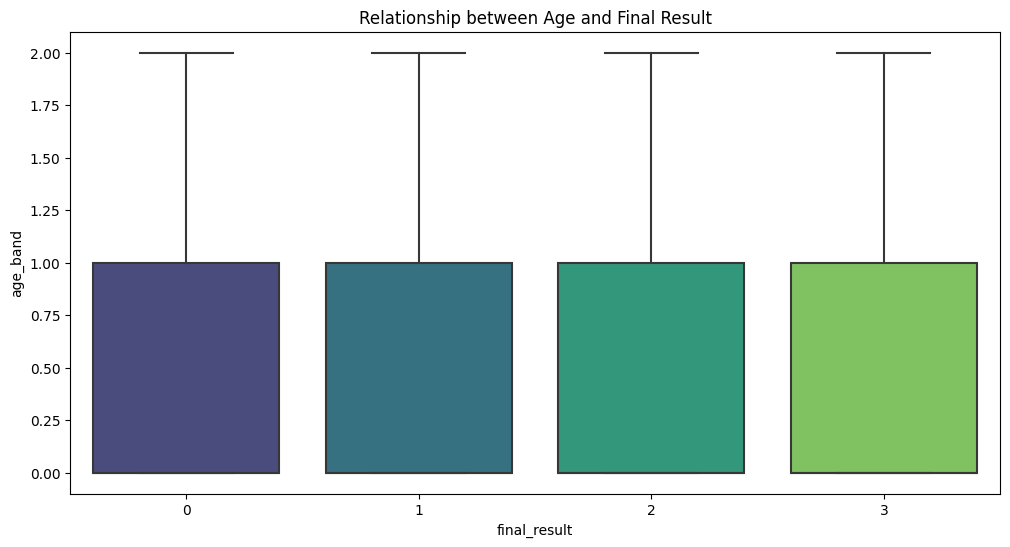

In [90]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='final_result', y='age_band', data=df_merged, palette='viridis')
plt.title('Relationship between Age and Final Result')
plt.show()

# Convert 'gender' column to categorical type
df_merged['gender'] = df_merged['gender'].astype('category')

# Countplot for the relationship between Gender and Final Result




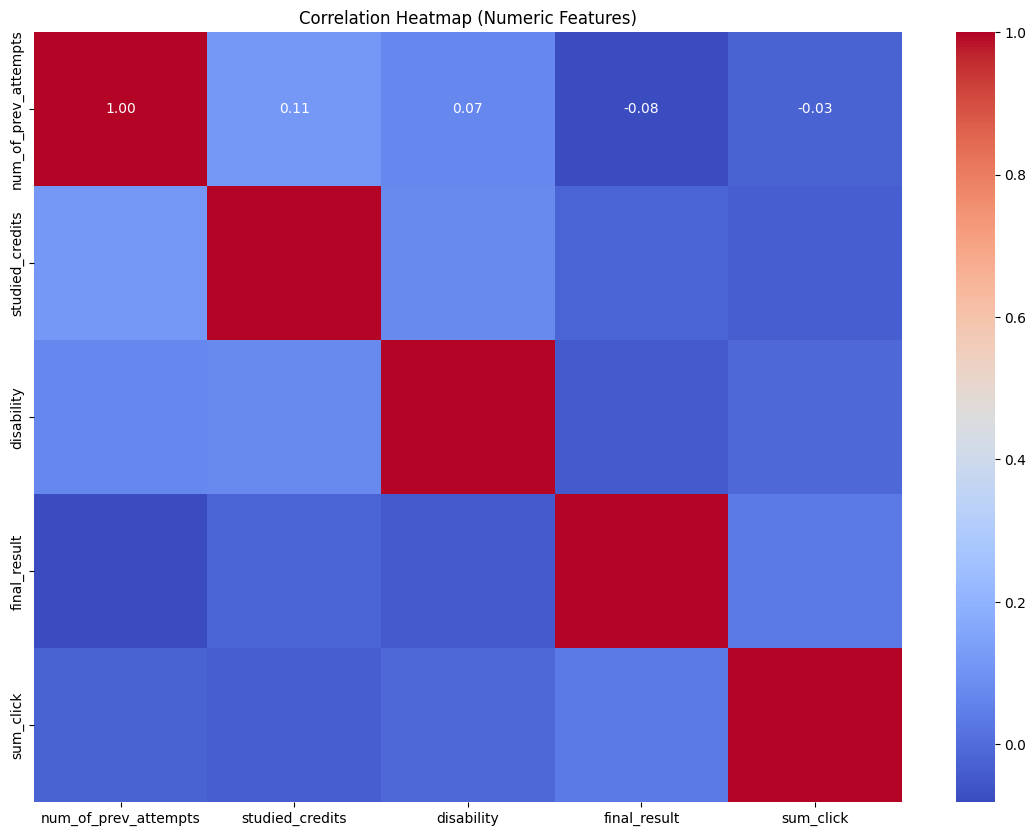

In [91]:
# Drop 'id_student' and 'id_site' columns before correlation analysis
df_for_correlation = df_merged.drop(['id_student', 'id_site'], axis=1)

# Select only numeric columns for correlation analysis
numeric_columns = df_for_correlation.select_dtypes(include=['float64', 'int64']).columns
numeric_df = df_for_correlation[numeric_columns]

# Correlation heatmap
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()


<span style=" font-size: 30px;">Random Forest</span><br><br>


In the context of supervised learning, where the algorithm learns from labeled training data to make predictions or decisions, classification plays a pivotal role. Classification involves assigning predefined labels or categories to input data based on its features. Random Forest, as a non-linear and ensemble model, excels in capturing complex interactions and avoiding overfitting. It enhances model robustness and predictive performance by identifying significant aspects contributing to student engagement. 

In [92]:
X = df_merged.drop(['code_module', 'code_presentation', 'id_student', 'final_result', 'date', 'age_band','gender'], axis=1)
y = df_merged['final_result']
print(df_merged)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

#  prediction
y_pred = model.predict(X_test)

# Evaluate 
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

       code_module code_presentation  id_student gender  region  \
0              AAA             2013J       11391      0       0   
1              AAA             2013J       11391      0       0   
2              AAA             2013J       11391      0       0   
3              AAA             2013J       11391      0       0   
4              AAA             2013J       11391      0       0   
...            ...               ...         ...    ...     ...   
549141         CCC             2014J     2691861      0       3   
549142         CCC             2014J     2691861      0       3   
549143         CCC             2014J     2691861      0       3   
549144         CCC             2014J     2691861      0       3   
549145         CCC             2014J     2691861      0       3   

        highest_education  imd_band  age_band  num_of_prev_attempts  \
0                       1         9         2                     0   
1                       1         9         2        

I didn't see a good relation between age_band and final result so I decided to ignore it until further exploration

explaining the code : I dropped the irrelavant columns and I put them into 'x' which are train elements. 'y' is final result that we wanna predict. I chose the test size to be 30%.
then I got the results

In [93]:
X = df_merged.drop(['code_module', 'code_presentation', 'id_student', 'final_result', 'date', 'age_band'], axis=1)
y = df_merged['final_result']
print(df_merged)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

#  prediction
y_pred = model.predict(X_test)

# Evaluate 
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)


       code_module code_presentation  id_student gender  region  \
0              AAA             2013J       11391      0       0   
1              AAA             2013J       11391      0       0   
2              AAA             2013J       11391      0       0   
3              AAA             2013J       11391      0       0   
4              AAA             2013J       11391      0       0   
...            ...               ...         ...    ...     ...   
549141         CCC             2014J     2691861      0       3   
549142         CCC             2014J     2691861      0       3   
549143         CCC             2014J     2691861      0       3   
549144         CCC             2014J     2691861      0       3   
549145         CCC             2014J     2691861      0       3   

        highest_education  imd_band  age_band  num_of_prev_attempts  \
0                       1         9         2                     0   
1                       1         9         2        

Accuracy: 0.82 with 0,2 test 
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70     20421
           1       0.76      0.62      0.68     17056
           2       0.85      0.91      0.88     95803
           3       0.79      0.77      0.78     31464

    accuracy                           0.82    164744
   macro avg       0.79      0.74      0.76    164744
weighted avg       0.82      0.82      0.82    164744

by adding age_band I saw that the accuracy has been increased so I think I need to have it until we can get the acctual data from HU

macro avg  gives equal weight to each class and make  it useful when I want to evaluate the overall performance without considering class imbalances.
weighted avg  means that classes with larger support have more influence on the weighted average. 
I saw better accuracy in all 3 terms so I think age_band can be an important factor in terms of predicting risk of failure.

I also changed the test size to see the difference but nothing changed so I think the accuracy of random forest is good enough although I don't have enough elements to predict studnets' risk of failure.

by droping gender the accuracy of the model has fallen, I think that could be in the result of the ratio of genders and the model has been overfitted.by getting more data I think this problem will be solved

In [95]:

X = df_merged.drop(['code_module', 'code_presentation', 'id_student', 'final_result', 'date'], axis=1)
y = df_merged['final_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76     20421
           1       0.82      0.70      0.75     17056
           2       0.88      0.93      0.90     95803
           3       0.84      0.83      0.84     31464

    accuracy                           0.86    164744
   macro avg       0.84      0.79      0.81    164744
weighted avg       0.86      0.86      0.86    164744



<span style=" font-size: 30px;">Results:</span><br><br>
Random Forest Model Performance with 0,2 test 

               precision    recall  f1-score   support

           0       0.81      0.73      0.77     13496
           1       0.83      0.70      0.76     11322
           2       0.88      0.93      0.91     64084
           3       0.85      0.84      0.84     20928

    accuracy                           0.86    109830
   macro avg       0.84      0.80      0.82    109830
weighted avg       0.86      0.86      0.86    109830


<span style=" font-size: 30px;">Evaluation :</span><br><br>
The classification report suggests that the model performs well across all classes, with high precision, recall, and F1-scores.This means that the model effectively identifies true positives, minimizes false positives, and captures a high percentage of actual positive instances. The weighted averages indicate a balanced performance, considering the distribution of instances in each class. The model shows a strong ability to correctly classify instances, particularly for classes 2(pass) and 3(distinction). However, it's important to consider the specific requirements of the application and potential implications of false positives and false negatives. Further analysis, such as exploring misclassified instances or adjusting the model's parameters, could provide additional insights and improvements. Overall, the interpretation demonstrates a thorough understanding of the model's performance, considering multiple evaluation metrics.







<span style=" font-size: 30px;">Discussion :</span><br><br>

one area that the model could be improved is in its ability to predict if a student will pass or distinction. The precision and recall for classes 2 and 3 are slightly lower than the precision and recall for classes 0 and 1. This shows that the model  misclassified students as failing or withdrawing when they are actually likely to succeed.A false positive (predicting success when a student  fail) leads to confidence, while a false negative (predicting failure when a student will pass) could result in not being  supported. 

the reason behind this is that can be the features used to predict the final_result are not as effective at predicting success as they are at predicting failure or withdrawal. This could be because the features are not as relevant to success as they are to failure or withdrawal.
the overall performance of the model is very good. It is able to make accurate predictions about the final_result for most of the test samples. With some further refinement, the model could even be more accurate.




<span style=" font-size: 30px;">Future :</span><br><br>


the project will employ Ensemble Models in Predictive Analysis, (like Random Forest and Logistic Regression). This approach enhances accuracy by using the strengths of each model. The dynamic feedback loop mechanism enables continuous learning, with lecturer's feedback contributing to model refinement. This adaptive system ensures ongoing optimization for predicting student engagement.

The combination of Logistic Regression and Random Forest models in predictive analysis provides a good approach for understanding and predicting student engagement. Logistic Regression, being a linear model, offers interpretability by revealing the strength and direction of relationships between input features and engagement likelihood. This transparency allows Lecturers to grasp specific factors influencing engagement. On the other hand, Random Forest, as a non-linear and ensemble model, excels in capturing complex interactions and avoiding overfitting. It enhances model robustness and predictive performance by identifying significant aspects contributing to student engagement. 
The  integration of Logistic Regression and Random Forest models maximizes the strengths of each, enhancing accuracy and facilitating continuous learning through a dynamic feedback loop. This synergistic approach not only improves precision but also establishes a symbiotic relationship between the predictive model and Lecturer. The incorporation of a feedback mechanism is pivotal, refining model accuracy and ensuring fairness by allowing teachers to provide valuable insights. This collaborative loop empowers educators to inform the system about specific student nuances, mitigating biases, and enhancing the overall precision of the analysis. In essence, this iterative feedback process not only enhances the predictive model's capabilities but also fosters a more nuanced and equitable evaluation of student engagement in digital learning environments.




<span style=" font-size: 30px;">References :</span><br><br>


Dalkir, K., & Lee, C. S. (2011). A dynamic feedback loop approach to improving the effectiveness of a knowledge management system: A comparative case study. The Journal of Strategic Information Systems, 20(1), 1-27.

Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.

Baker, R. S., & Yacef, K. (2009). The state of assessment tools for open learning environments. The Internet and Higher Education, 12(3-4), 195-208.

Hung, D., Chen, C., & Kinshuk, K. (2010). Predicting student performance in online learning environments. Educational Technology Research and Development, 58(6), 781-806.



